In [1]:
#include "cali.h"
#include <iostream>
#include <map>

using namespace std;

In [2]:
//get data from 335 file
TFile *ipf = new TFile("~/data/cali00335.root");
TTree *tree = (TTree*)ipf->Get("tree");
TCanvas *c1=new TCanvas("c1","c1");
Double_t e;
ULong64_t ts;
Int_t fr,str,det;
tree->SetBranchAddress("e",&e);
tree->SetBranchAddress("ts",&ts);
tree->SetBranchAddress("fr",&fr);
tree->SetBranchAddress("str",&str);
tree->SetBranchAddress("det",&det);
tree->Print();

******************************************************************************
*Tree    :tree      : tree                                                   *
*Entries :   690749 : Total =        19397029 bytes  File  Size =    5492309 *
*        :          : Tree compression factor =   3.53                       *
******************************************************************************
*Br    0 :e         : e/D                                                    *
*Entries :   690749 : Total  Size=    5541601 bytes  File Size  =    1993333 *
*Baskets :      174 : Basket Size=      32000 bytes  Compression=   2.78     *
*............................................................................*
*Br    1 :ts        : ts/l                                                   *
*Entries :   690749 : Total  Size=    5541779 bytes  File Size  =    3179230 *
*Baskets :      174 : Basket Size=      32000 bytes  Compression=   1.74     *
*...................................................

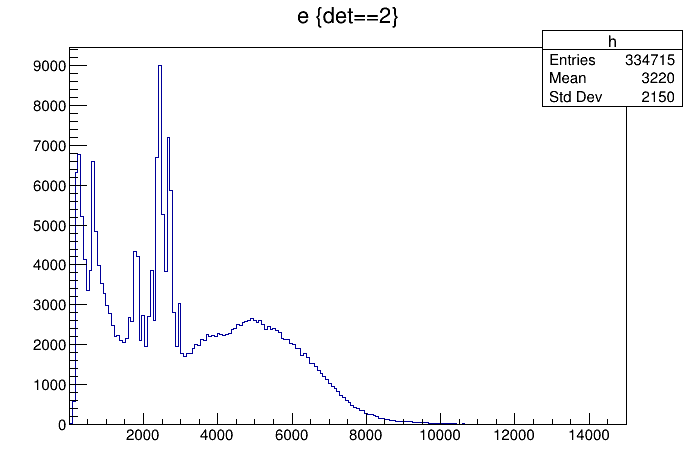

In [3]:
tree->Draw("e>>h(200,10,15000)","det==2");
c1->Draw();

## amplitude from front and back sides

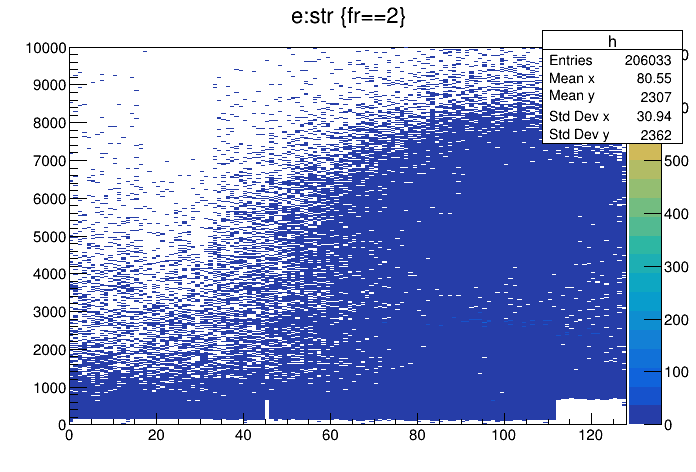

In [4]:
tree->Draw("e:str>>h(128,0,128,1000,0,10000)","fr==2","colz");
c1->Draw();

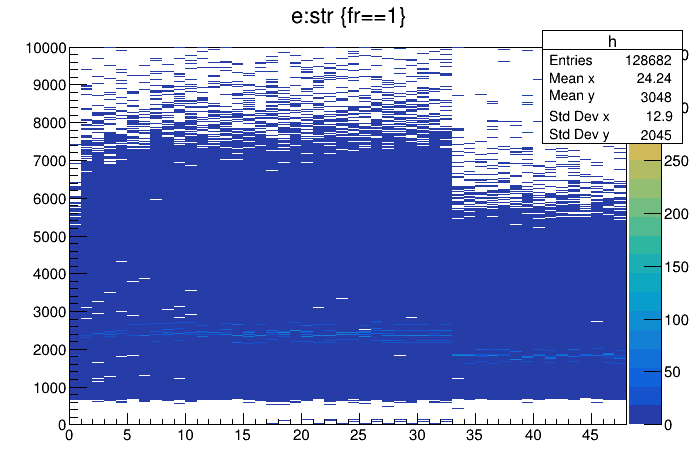

In [5]:
tree->Draw("e:str>>h(48,0,48,1000,0,10000)","fr==1","colz");
c1->Draw();

In [6]:
//events sort and output variable
struct dect {
    Int_t str;
    Double_t e;
    ULong64_t ts;
};

multimap<ULong64_t, dect> mapts_f,mapts_b,mapts_mw,mapts_ve;
multimap<ULong64_t, dect>::iterator its,jts;
dect dts;

In [7]:
for(Int_t i=0;i<tree->GetEntriesFast();i++){
    tree->GetEntry(i);
    if(det==4) continue;
    dts.str=str;
    dts.e=e;
    dts.ts=ts;
    if(det==1) mapts_mw.insert(pair<ULong64_t,dect> (ts,dts));
    if(det==2&&fr==1) mapts_f.insert(pair<ULong64_t,dect> (ts,dts));
    if(det==2&&fr==2) mapts_b.insert(pair<ULong64_t,dect> (ts,dts));
    if(det==3) mapts_ve.insert(pair<ULong64_t,dect> (ts,dts));
    if(i%10000==0) cout<<"*";
    //if(i<100)cout<<ts<<"  "<<det<<"  "<<fr<<"  "<<str<<"  "<<e<<endl;
}
cout<<endl;
cout<<" Total events:"<<mapts_f.size()<<"  "<<mapts_b.size()<<endl;
cout<<" size mwpc:"<<mapts_mw.size()<<"  "<<"size veto:"<<mapts_ve.size()<<endl;
ipf->Close();

**********************************************************************
 Total events:128682  206033
 size mwpc:353898  size veto:2136


In [8]:
//check the events 
its = mapts_f.begin();
for(Int_t i=0;i<10;i++){
    cout<<its->first<<"  "<<its->second.e<<"  "<<its->second.str<<endl;
    its++;
}

1339474350  2169  11
9022757640  3843  3
9122771170  6592  24
9202986900  4836  31
9305276750  3910  27
9418690000  5836  29
9423589230  4979  37
9441338680  6306  43
9470639040  5513  8
9531671070  5429  22


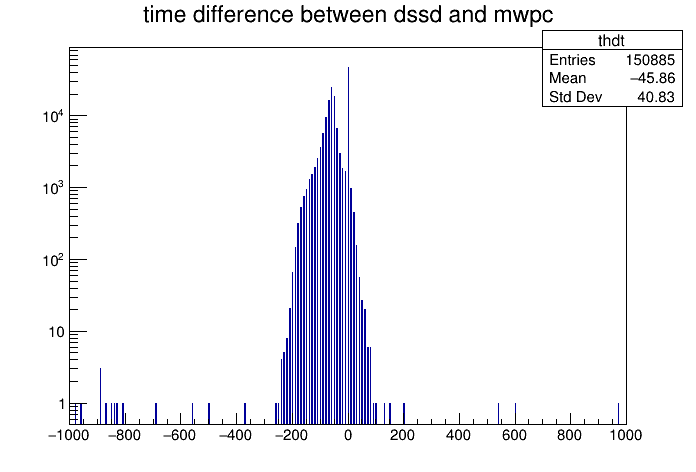

In [9]:
//time difference between dssd and mwpc
ULong64_t twin=10000;
TH1F *thdt = new TH1F("thdt","time difference between dssd and mwpc",1000,-1000,1000);
for(its=mapts_b.begin();its!=mapts_b.end();its++){
    for(jts=mapts_mw.lower_bound(its->first-twin);jts!=mapts_mw.end();jts++){
        if(its->first+twin<jts->first) break;
        Int_t dt = jts->first-its->first;
        thdt->Fill(dt);
        jts++;
    }
}
thdt->Draw();
c1->SetLogy();
c1->Draw();
TTree *opt = new TTree("tree","tree");

In [10]:
void BranchOpt(){
  opt->Branch("xhit",&xhit,"xhit/I");
  opt->Branch("yhit",&yhit,"yhit/I");
  opt->Branch("x",&x,"x[xhit]/I");
  opt->Branch("y",&y,"y[yhit]/I");
  opt->Branch("xe",&xe,"xe[xhit]/D");
  opt->Branch("ye",&ye,"ye[yhit]/D");
  opt->Branch("xt",&xt,"xt[xhit]/l");
  opt->Branch("yt",&yt,"yt[yhit]/l");
  opt->Branch("ve",ve,"ve[3]/D");
  opt->Branch("vt",vt,"vt[3]/D");
  opt->Branch("mwe",&mwe,"mwe/D");
  opt->Branch("mwt",&mwt,"mwt/l");
}

In [11]:
//event calssification and time sort
TFile *otf = new TFile("sort00335.root","recreate");
twin=500;
BranchOpt();
Int_t count=0;
for(its=mapts_b.begin();its!=mapts_b.end();its++){
    ResetOpt();
    
    x[xhit]=its->second.str;
    xt[xhit]=its->first;
    xe[xhit]=its->second.e;
    xhit++;
    for(jts=mapts_b.lower_bound(its->first-twin);jts!=mapts_b.end();jts++){
        if(its->first+twin<jts->first) break;
        if(xhit>10) continue;
        if(its->first==jts->first)continue;
        x[xhit]=jts->second.str;
        xt[xhit]=jts->first;
        xe[xhit]=jts->second.e;
        xhit++;        
    }    
    
    for(jts=mapts_f.lower_bound(its->first-twin);jts!=mapts_f.end();jts++){
        if(its->first+twin<jts->first) break;
        if(yhit>10) continue;
        y[yhit]=jts->second.str;
        yt[yhit]=jts->first;
        ye[yhit]=jts->second.e;
        yhit++;          
    }
    
    for(jts=mapts_mw.lower_bound(its->first-twin);jts!=mapts_mw.end();jts++){
        if(its->first+twin<jts->first) break;
        mwe=jts->second.e;
        mwt=jts->first;
    }

    for(jts=mapts_ve.lower_bound(its->first-twin);jts!=mapts_ve.end();jts++){
        if(its->first+twin<jts->first) break;
        Int_t n;
        n=jts->second.str;
        ve[n]=jts->second.e;
        vt[n]=jts->first;
    }
    opt->Fill();
    if(count<10) cout<<x[0]<<"  "<<y[0]<<endl;
    count++;
    if(count%4000==0) cout<<" "<<count;
}
opt->Write();
otf->Close();
cout<<" file done!"<<endl;

97  0
94  11
55  0
48  3
121  24
76  31
77  31
91  27
79  29
100  37
 4000 8000 12000 16000 20000 24000 28000 32000 36000 40000 44000 48000 52000 56000 60000 64000 68000 72000 76000 80000 84000 88000 92000 96000 100000 104000 108000 112000 116000 120000 124000 128000 132000 136000 140000 144000 148000 152000 156000 160000 164000 168000 172000 176000 180000 184000 188000 192000 196000 200000 204000 file done!
